In [104]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ahrs
from ahrs.filters import EKF
from ahrs.common.orientation import q2R, acc2q, rpy2q, q2euler



# DATA_DIR = './random_test/'
# DATA_FILE = '9.csv'     # Medium Frequency Disturbance test
# DATA_FILE = '10.csv'    # Medium Frequency Disturbance test
# DATA_FILE = '11.csv'    # High Frequency Disturbance test
# DATA_FILE = '13.csv'    # LOW Frequency Disturbance test

# DATA_DIR = './walks/inside_elab/'
# DATA_FILE = 'trax_2025_4_24_23_24_13_#15.csv'
# DATA_FILE = 'trax_2025_4_24_23_26_16_#18.csv'

DATA_DIR = './walks/outside_elab/new/'
DATA_FILE = 'trax_2025_4_25_3_35_25_#27.csv'
# DATA_FILE = 'trax_2025_4_25_3_37_16_#28.csv'


raw_data = pd.read_csv(DATA_DIR + DATA_FILE)
raw_data["timestamp"] = raw_data["timestamp"]- raw_data["timestamp"][0]
raw_data["IMU-ticks"] = raw_data["IMU-ticks"]- raw_data["IMU-ticks"][0]
raw_data["GPS-ticks"] = raw_data["GPS-ticks"]- raw_data["GPS-ticks"][0]
raw_data["pressure-ticks"] = raw_data["pressure-ticks"]- raw_data["pressure-ticks"][0]


# Extract IMU data
acc_raw_data = raw_data[['aX', 'aY', 'aZ']].to_numpy() #m/s2
gyro_raw_data = raw_data[['gX', 'gY', 'gZ']].to_numpy() #rad/s
mag_raw_data = raw_data[['mX', 'mY', 'mZ']].to_numpy() #uT
gps_raw_data = raw_data[['lat', 'long']].to_numpy() / 1e7

mag_raw_data /= 1000 # the library expects mT
timestamps_in_ms = raw_data['IMU-ticks'].to_numpy()
timestamps_in_seconds = timestamps_in_ms * 1000.0
time_deltas = np.diff(timestamps_in_ms) / 1000.0  # Convert ms to seconds
time_deltas = np.append(time_deltas, time_deltas[-1])  # Same length as data


# Determine the minimum length among the arrays
min_length = min(len(acc_raw_data), len(gyro_raw_data), len(mag_raw_data), len(gps_raw_data), len(timestamps_in_ms), len(time_deltas))

# Trim all arrays to the minimum length
acc_raw_data = acc_raw_data[:min_length]
gyro_raw_data = gyro_raw_data[:min_length]
mag_raw_data = mag_raw_data[:min_length]
gps_raw_data = gps_raw_data[:min_length]
timestamps_in_ms = timestamps_in_ms[:min_length]
time_deltas = time_deltas[:min_length]

# Now all arrays have the same length


print(f"Average sampling period: {np.average(time_deltas):.4f} seconds")
print(f"Approximate sampling frequency: {1/np.average(time_deltas):.2f} Hz")

Average sampling period: 0.0362 seconds
Approximate sampling frequency: 27.61 Hz


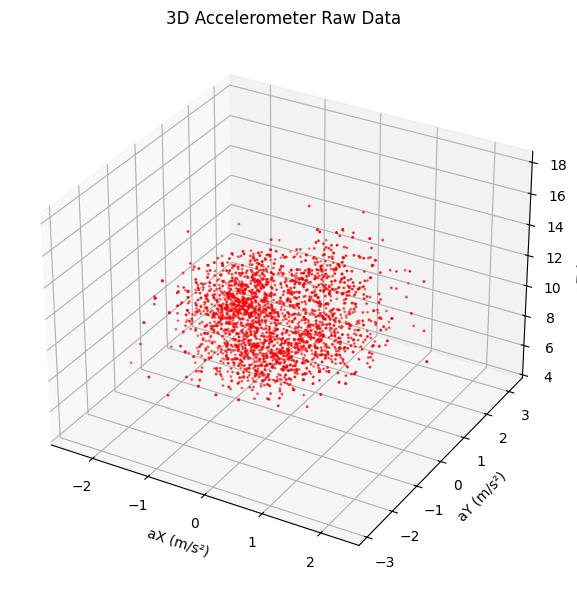

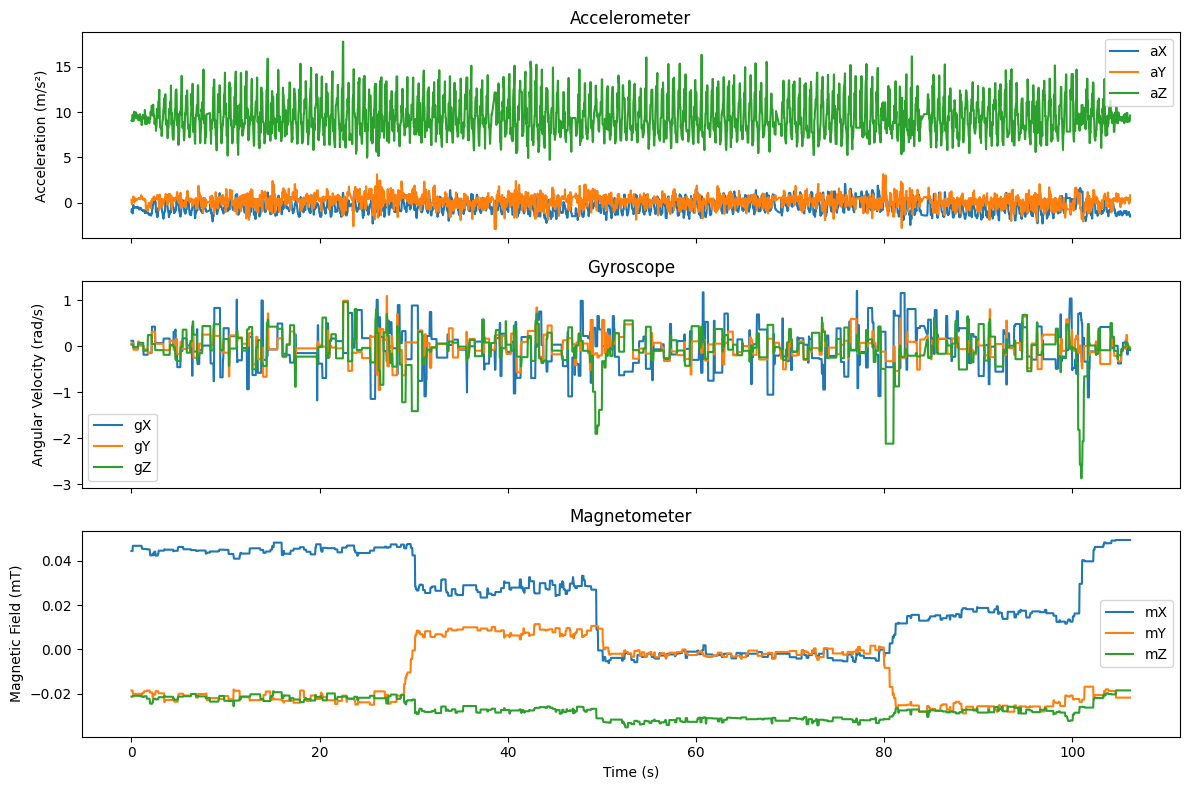

In [105]:

# --- 1. 3D Scatter plot of raw accelerometer data ---
fig = plt.figure(figsize=(8, 6))
accel_x_raw = fig.add_subplot(111, projection='3d')
accel_x_raw.scatter(acc_raw_data[:, 0], acc_raw_data[:, 1], acc_raw_data[:, 2], c='r', marker='o', s=1)
accel_x_raw.set_xlabel('aX (m/s²)')
accel_x_raw.set_ylabel('aY (m/s²)')
accel_x_raw.set_zlabel('aZ (m/s²)')
accel_x_raw.set_title('3D Accelerometer Raw Data')
plt.tight_layout()
plt.show()

# --- 2. Raw IMU Data over Time ---
timstamps_in_sec = timestamps_in_ms / 1000.0

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Accelerometer
axs[0].plot(timstamps_in_sec, acc_raw_data)
axs[0].set_ylabel('Acceleration (m/s²)')
axs[0].legend(['aX', 'aY', 'aZ'])
axs[0].set_title('Accelerometer')

# Gyroscope
axs[1].plot(timstamps_in_sec, gyro_raw_data)
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend(['gX', 'gY', 'gZ'])
axs[1].set_title('Gyroscope')

# Magnetometer
axs[2].plot(timstamps_in_sec, mag_raw_data)
axs[2].set_ylabel('Magnetic Field (mT)')
axs[2].legend(['mX', 'mY', 'mZ'])
axs[2].set_title('Magnetometer')
axs[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()


# Compelmentary Filter

## Orientation Estimation using Gyroscope

In [106]:

# Unpack the columns into ax, ay, az
gyro_x, gyro_y, gyro_z = zip(*gyro_raw_data)

# Convert tuples to NumPy arrays
gyro_x = np.array(gyro_x)
gyro_y = np.array(gyro_y)
gyro_z = np.array(gyro_z)

roll_from_gyro = np.zeros(len(timstamps_in_sec))
pitch_from_gyro = np.zeros(len(timstamps_in_sec))
yaw_from_gyro = np.zeros(len(timstamps_in_sec))

DT = np.diff(timstamps_in_sec, prepend=0)

# Apply complementary filter iteratively
for i in range(1, len(timstamps_in_sec)):
    # Calculate gyroscope integration
    roll_from_gyro[i] = roll_from_gyro[i-1] + gyro_x[i] * DT[i]  # Integrate gyroscope for roll
    pitch_from_gyro[i] = pitch_from_gyro[i-1] + gyro_y[i] * DT[i]  # Integrate gyroscope for pitch
    yaw_from_gyro[i] = yaw_from_gyro[i-1] + gyro_z[i] * DT[i]  # Integrate gyroscope for yaw
    

## Orientation Estimation using Accelerometer and Magnetometer

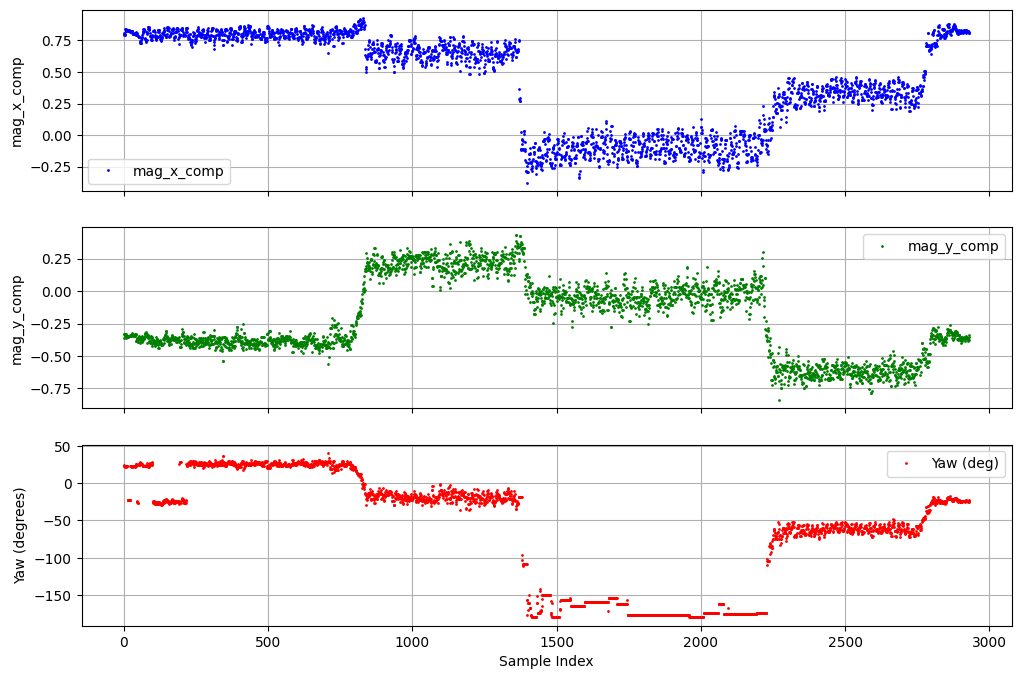

In [107]:
from scipy.ndimage import uniform_filter1d

# Calculating Roll and Pitch from acceleration
# Unpack the columns into ax, ay, az
accel_x_raw, accel_y_raw, accel_z_raw = zip(*acc_raw_data)

# Convert tuples to NumPy arrays
accel_x_raw = np.array(accel_x_raw)
accel_y_raw = np.array(accel_y_raw)
accel_z_raw = np.array(accel_z_raw)

roll_from_accel = np.arctan2(accel_y_raw, accel_z_raw)
pitch_from_accel = np.arctan2(-accel_x_raw, np.sqrt(accel_y_raw**2 + accel_z_raw**2))

# Calculating Yaw from acceleration
mag_x, max_y, max_z = zip(*mag_raw_data)

mag_x = np.array(mag_x)
mag_y = np.array(max_y)
mag_z = np.array(max_z)

mag_norm = np.sqrt(mag_x**2 + mag_y**2 + mag_z**2)
mag_x /= mag_norm
mag_y /= mag_norm
mag_z /= mag_norm



# Tilt compensation
cos_roll = np.cos(roll_from_accel)
sin_roll = np.sin(roll_from_accel)
cos_pitch = np.cos(pitch_from_accel)
sin_pitch = np.sin(pitch_from_accel)

mag_x_comp = mag_x * cos_pitch + mag_z * sin_pitch
mag_y_comp = (mag_x * sin_roll * sin_pitch +
              mag_y * cos_roll -
              mag_z * sin_roll * cos_pitch)

mag_norm = np.sqrt(mag_x_comp**2 + mag_y_comp**2)

# ###########################################
# yaw_magnet = np.zeros_like(mag_norm)

# MAG_THRESHOLD = 0.3 # Adjust based on your sensor scale, e.g., microteslas
# valid = mag_norm > MAG_THRESHOLD  # Boolean mask for strong magnetic field data

# yaw_temp = np.arctan2(-mag_y_comp, mag_x_comp)

# yaw_magnet[0] = yaw_temp[0] if valid[0] else 0.0
# for i in range(1, len(yaw_magnet)):
#     if valid[i]:
#         yaw_magnet[i] = yaw_temp[i]
#     else:
#         yaw_magnet[i] = yaw_magnet[i - 1]  # Use last good value

# yaw_temp = np.arctan2(-mag_y_comp, mag_x_comp)
# ###########################################


# ############################################
# Ensure proper types
mag_x_comp = np.asarray(mag_x_comp, dtype=np.float64)
mag_y_comp = np.asarray(mag_y_comp, dtype=np.float64)

# Compute temporary yaw values (magnetometer-based)
yaw_temp = np.abs(np.arctan2(mag_y_comp, mag_x_comp))  # Only take magnitude

# Magnitude of the horizontal magnetic vector
mag_norm = np.sqrt(np.maximum(1e-8, mag_x_comp**2 + mag_y_comp**2))
MAG_THRESHOLD = 0.2  # in uT or adjusted to your sensor scale
valid_mag = mag_norm > MAG_THRESHOLD

# Compute local variance (sliding window)
window_size = 10  # Tunable
yaw_var = uniform_filter1d(yaw_temp**2, size=window_size) - uniform_filter1d(yaw_temp, size=window_size)**2

# Variance threshold
VAR_THRESHOLD = 0.05  # Adjust based on noise
valid_var = yaw_var < VAR_THRESHOLD

# Combined validity mask
valid = valid_mag & valid_var


# Initialize magnetometer-based yaw
yaw_magnet = np.zeros_like(yaw_temp)
yaw_magnet[0] = yaw_temp[0] if valid[0] else 0.0

# Propagate with gyro orientation continuity
for i in range(1, len(yaw_magnet)):
    if valid[i]:
        yaw_magnet[i] = np.abs(yaw_temp[i]) * np.sign(yaw_from_gyro[i])
    else:
        yaw_magnet[i] = yaw_magnet[i - 1]  # Hold last good magnitude
# ############################################



fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 1. Plot mag_x_comp
axs[0].plot(mag_x_comp, label='mag_x_comp', color='blue', marker="o", markersize=1, linestyle="none")
axs[0].set_ylabel('mag_x_comp')
axs[0].legend()
axs[0].grid()

# 2. Plot mag_y_comp
axs[1].plot(mag_y_comp, label='mag_y_comp', color='green', marker="o", markersize=1, linestyle="none")
axs[1].set_ylabel('mag_y_comp')
axs[1].legend()
axs[1].grid()

# 3. Plot raw yaw (in degrees)
axs[2].plot(np.degrees(yaw_magnet), label='Yaw (deg)', color='red', marker="o", markersize=1, linestyle="none")
axs[2].set_ylabel('Yaw (degrees)')
axs[2].set_xlabel('Sample Index')
axs[2].legend()
axs[2].grid()

In [108]:
# # Calculating Roll and Pitch from acceleration
# # Unpack the columns into ax, ay, az
# accel_x_raw, accel_y_raw, accel_z_raw = zip(*acc_raw_data)

# # Convert tuples to NumPy arrays
# accel_x_raw = np.array(accel_x_raw)
# accel_y_raw = np.array(accel_y_raw)
# accel_z_raw = np.array(accel_z_raw)

# # # Print the extracted values
# # print("ax:", ax)
# # print("ay:", ay)
# # print("az:", az)

# roll_from_accel = np.arctan2(accel_y_raw, accel_z_raw)
# pitch_from_accel = np.arctan2(-accel_x_raw, np.sqrt(accel_y_raw**2 + accel_z_raw**2))


# # Calculating Yaw from acceleration
# mag_x, max_y, max_z = zip(*mag_raw_data)

# mag_x = np.array(mag_x)
# mag_y = np.array(max_y)
# mag_z = np.array(max_z)

# mag_norm = np.sqrt(mag_x**2 + mag_y**2 + mag_z**2)
# mag_x /= mag_norm
# mag_y /= mag_norm
# mag_z /= mag_norm



# # Tilt compensation
# cos_roll = np.cos(roll_from_accel)
# sin_roll = np.sin(roll_from_accel)
# cos_pitch = np.cos(pitch_from_accel)
# sin_pitch = np.sin(pitch_from_accel)

# mag_x_comp = mag_x * cos_pitch + mag_z * sin_pitch
# mag_y_comp = (mag_x * sin_roll * sin_pitch +
#               mag_y * cos_roll -
#               mag_z * sin_roll * cos_pitch)

# yaw_rad = np.arctan2(-mag_y_comp, mag_x_comp)
# yaw_unwrapped = np.unwrap(yaw_rad)

# # Optional: moving average smoothing
# def moving_average(x, window_size=2):
#     return np.convolve(x, np.ones(window_size)/window_size, mode='same')

# yaw_smoothed = moving_average(yaw_unwrapped, window_size=10)
# yaw_deg = np.degrees(yaw_smoothed)

# # Normalize to [-180, 180]
# yaw_normalized = (yaw_deg + 180) % 360 - 180
# def normalize_angle_rad(angle):
#     return (angle + np.pi) % (2*np.pi) - np.pi

# yaw_magnet = normalize_angle_rad(yaw_smoothed)  # Final cleaned yaw in rad

# fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# # Accelerometer
# axs[0].plot(timstamps_in_sec, np.degrees(roll_from_accel), color='blue', marker='o',  markersize=1, linestyle='None')
# axs[0].set_ylabel('Roll Angle (degrees)')
# axs[0].set_title('Roll Angle using Acce.')

# # Gyroscope
# axs[1].plot(timstamps_in_sec, np.degrees(pitch_from_accel), color='green', marker='o',  markersize=1, linestyle='None')
# axs[1].set_ylabel('Pitch Angle (degrees)')
# axs[1].set_title('Pitch Angle using Acce.')

# # Magnetometer
# axs[2].plot(timstamps_in_sec, np.degrees(yaw_magnet), color='red', marker='o',  markersize=1, linestyle='None')
# axs[2].set_ylabel('Yaw Angle (degrees)')
# axs[2].set_title('Yaw Angle using Mag.')
# axs[2].set_xlabel('Time (s)')

# plt.tight_layout()
# plt.show()


## Complimentary Filter

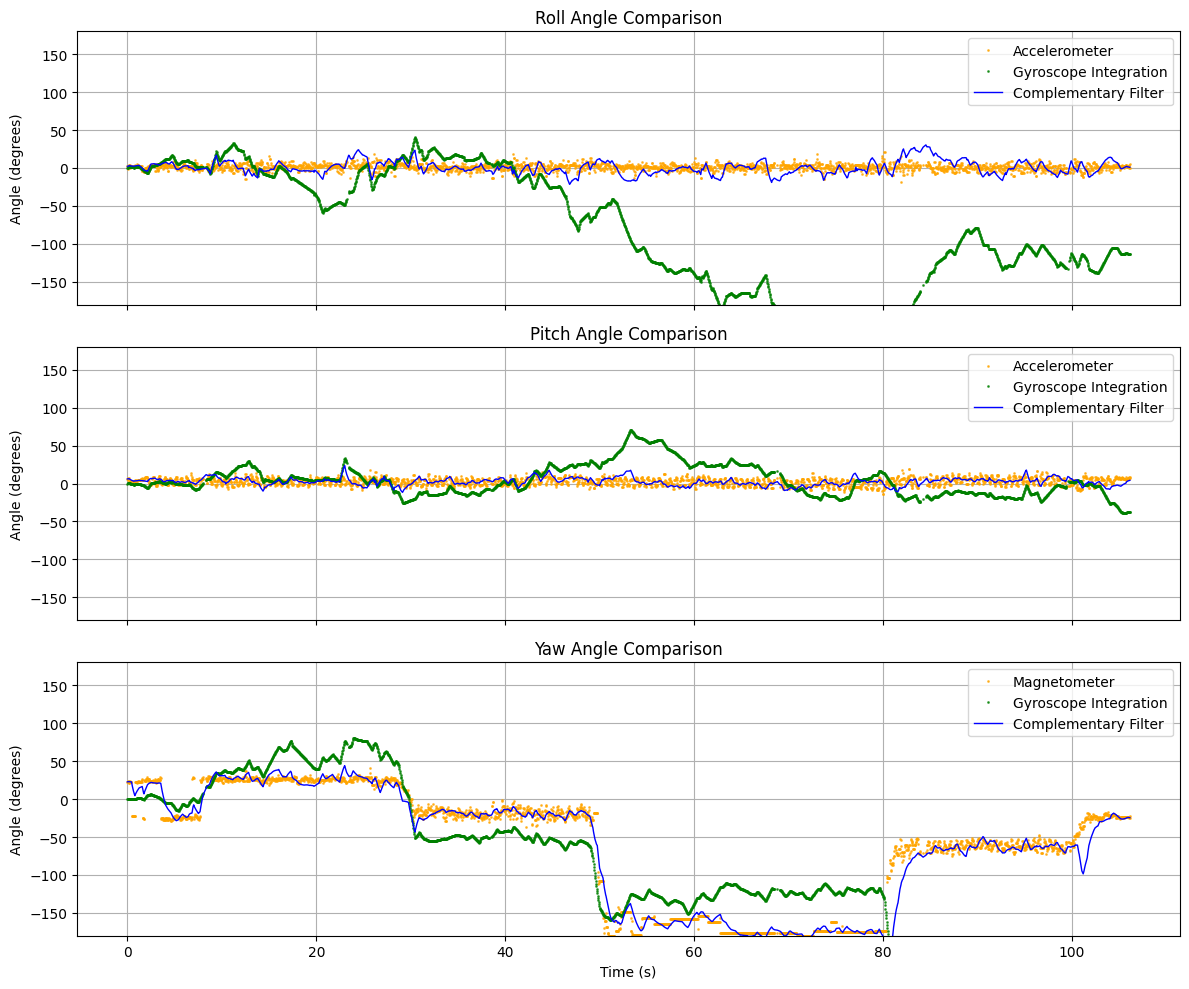

In [109]:

# Initialize arrays for filtered angles
roll_comp = np.zeros(len(timstamps_in_sec))
pitch_comp = np.zeros(len(timstamps_in_sec))
yaw_comp = np.zeros(len(timstamps_in_sec))

# Initialize arrays for gyro angles
roll_gyro = np.zeros(len(timstamps_in_sec))
pitch_gyro = np.zeros(len(timstamps_in_sec))
yaw_gyro = np.zeros(len(timstamps_in_sec))

# Initialize with first accelerometer reading
roll_comp[0] = roll_from_accel[0]
pitch_comp[0] = pitch_from_accel[0]
yaw_comp[0] = yaw_magnet[0]
prev_yaw = yaw_magnet[0]
yaw_offset = 0

# Constants for complementary filter
ALPHA = 0.95
# Weight for gyroscope (typically between 0.95-0.99)

# Apply complementary filter iteratively
for i in range(1, len(timestamps_in_ms)):
  # Calculate gyroscope integration
  roll_gyro[i] = roll_comp[i-1] + gyro_x[i] * DT[i]  # Integrate gyroscope for roll
  pitch_gyro[i] = pitch_comp[i-1] + gyro_y[i] * DT[i]  # Integrate gyroscope for pitch
  yaw_gyro[i] = yaw_comp[i-1] + gyro_z[i] * DT[i]  # Integrate gyroscope for yaw
  
  # Apply complementary filter
  roll_comp[i] = ALPHA * roll_gyro[i] + (1 - ALPHA) * roll_from_accel[i]
  pitch_comp[i] = ALPHA * pitch_gyro[i] + (1 - ALPHA) * pitch_from_accel[i]
  yaw_comp[i] = ALPHA * yaw_gyro[i] + (1 - ALPHA) * yaw_magnet[i]

  
# Plotting (same as before)
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Roll Angle
axs[0].plot(timstamps_in_sec, np.degrees(roll_from_accel), 'orange', label='Accelerometer', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[0].plot(timstamps_in_sec, np.degrees(roll_from_gyro), 'g', label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[0].plot(timstamps_in_sec, np.degrees(roll_comp), 'b', label='Complementary Filter', linewidth=1)  # Line for complementary filter
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Roll Angle Comparison')
axs[0].set_ylim(-180, 180)  # Set y-axis limits
axs[0].legend()
axs[0].grid(True)

# Pitch Angle
axs[1].plot(timstamps_in_sec, np.degrees(pitch_from_accel), 'orange', label='Accelerometer', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[1].plot(timstamps_in_sec, np.degrees(pitch_from_gyro), 'g', label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[1].plot(timstamps_in_sec, np.degrees(pitch_comp), 'b', label='Complementary Filter', linewidth=1)  # Line for complementary filter
axs[1].set_ylabel('Angle (degrees)')
axs[1].set_title('Pitch Angle Comparison')
axs[1].set_ylim(-180, 180)  # Set y-axis limits
axs[1].legend()
axs[1].grid(True)

# Yaw Angle
axs[2].plot(timstamps_in_sec, np.degrees(yaw_magnet), 'orange', label='Magnetometer', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[2].plot(timstamps_in_sec, np.degrees(yaw_from_gyro), 'g', label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')  # No line, only markers
axs[2].plot(timstamps_in_sec, np.degrees(yaw_comp), 'b', label='Complementary Filter', linewidth=1)  # Line for complementary filter
axs[2].set_ylabel('Angle (degrees)')
axs[2].set_title('Yaw Angle Comparison')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylim(-180, 180)  # Set y-axis limits
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Extended Kalman Filter
1. Process Noise (Gyroscope - MPU9250):
    - Typical gyro noise density: 0.01 dps/√Hz (dps = degrees per second)
    - Converted to rad/s: ~0.000175 rad/s/√Hz
    - For 100Hz sampling: ~0.0175 rad/s noise standard deviation
    - Variance: (0.0175)² ≈ 0.0003 rad²/s²
    - Conservative values chosen:
        - Roll/Pitch: 0.003 (slightly higher than calculated for margin)
        - Yaw: 0.005 (higher due to magnetometer influence)

2. Measurement Noise:
    - Accelerometer (Roll/Pitch):
      - MPU9250 accel noise: 300 μg/√Hz
      - At 1g, 300μg ≈ 0.003 rad (0.17°) noise
      - Variance: (0.003)² ≈ 0.000009 rad²
      - Conservative value: 0.05 (accounts for dynamic acceleration)

    - Magnetometer (Yaw):
      - AK8963 noise: 0.15 μT RMS
      - Earth field ~50 μT → ~0.003 rad (0.17°) noise
      - Variance: (0.003)² ≈ 0.000009 rad²
      - Conservative value: 0.1 (accounts for magnetic disturbances)

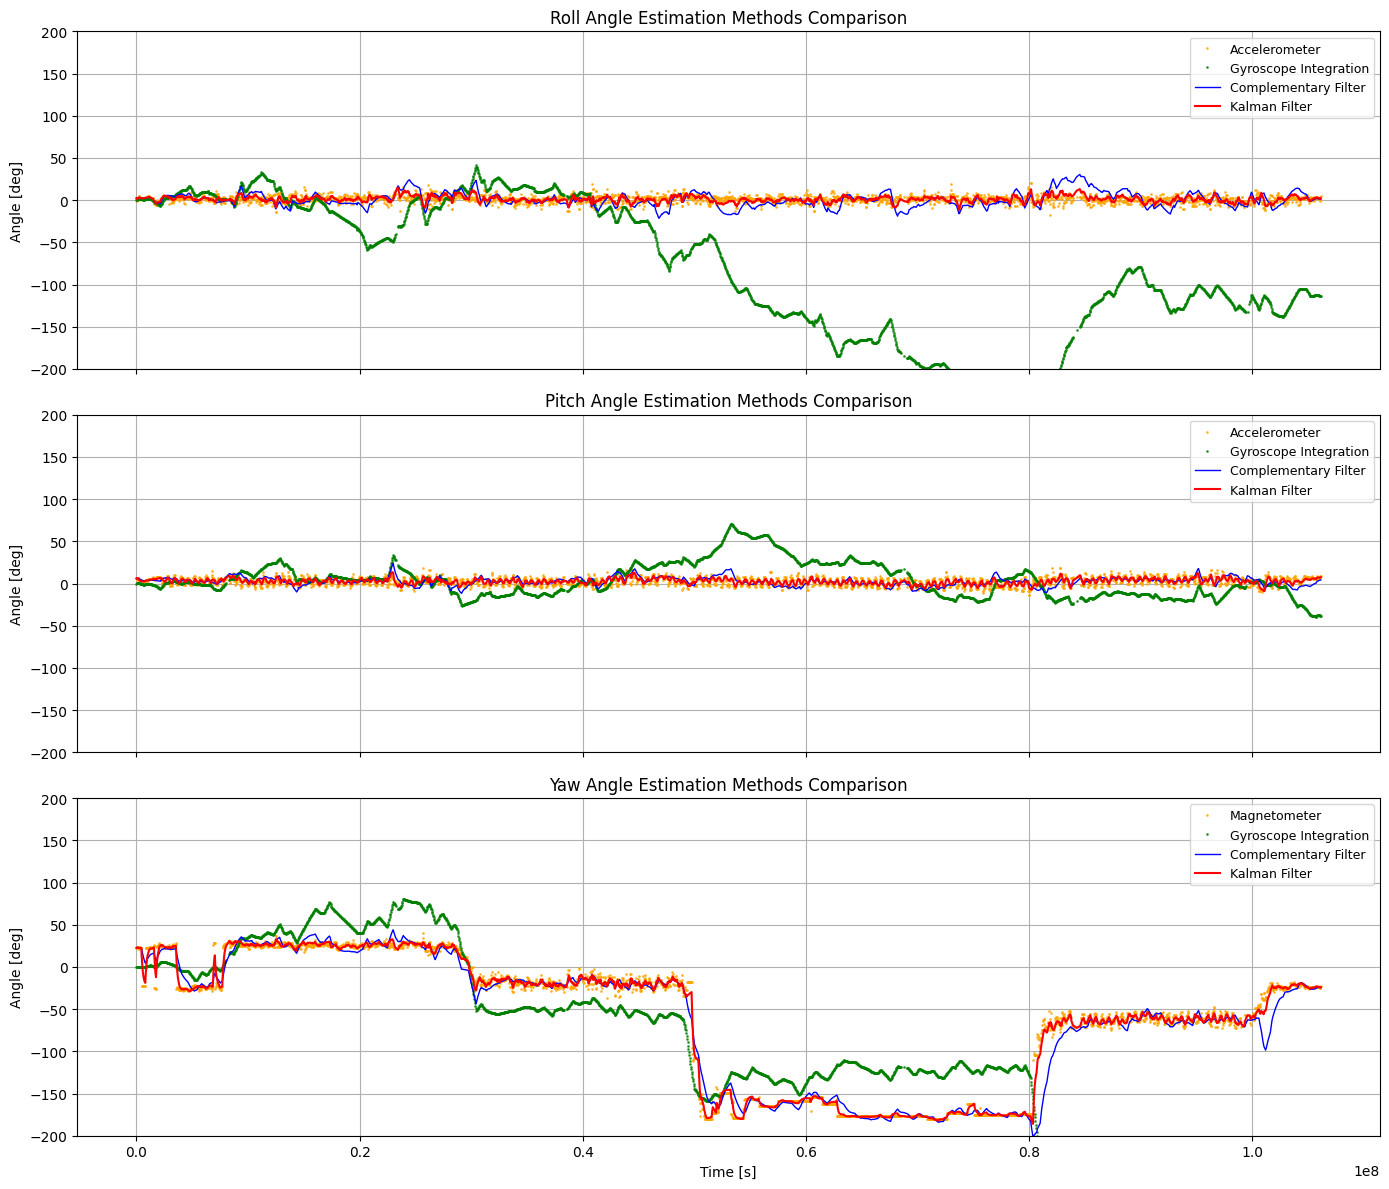

In [119]:
import numpy as np
from scipy.linalg import inv

class OrientationKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        """
        Initialize the Kalman Filter for orientation estimation
        
        Parameters:
            initial_state: Initial state vector [roll, pitch, yaw]
            initial_covariance: Initial covariance matrix (3x3)
            process_noise: Process noise covariance matrix (3x3)
            measurement_noise: Measurement noise covariance matrix (3x3)
        """
        self.state = initial_state  # [roll, pitch, yaw]
        self.covariance = initial_covariance
        self.Q = process_noise  # Process noise covariance
        self.R = measurement_noise  # Measurement noise covariance
        
        # State transition matrix (simple integration model)
        self.F = np.eye(3)
        
        # Measurement matrix (we directly observe all states)
        self.H = np.eye(3)
    
    def predict(self, gyro_rates, dt):
        """
        Prediction step using gyroscope data
        
        Parameters:
            gyro_rates: [roll_rate, pitch_rate, yaw_rate] in rad/s
            dt: Time step in seconds
        """
        # Update state (simple integration)
        self.state += gyro_rates * dt
        
        # Update covariance
        self.covariance = self.F @ self.covariance @ self.F.T + self.Q
        
        return self.state
    
    def update(self, accel_measurement, mag_measurement):
        """
        Update step using accelerometer and magnetometer data
        
        Parameters:
            accel_measurement: [roll_acc, pitch_acc] from accelerometer
            mag_measurement: yaw from magnetometer (after tilt compensation)
        """
        # Create measurement vector
        z = np.array([accel_measurement[0], accel_measurement[1], mag_measurement])
        
        # Kalman gain calculation
        S = self.H @ self.covariance @ self.H.T + self.R
        K = self.covariance @ self.H.T @ inv(S)
        
        # State update
        y = z - self.H @ self.state
        self.state += K @ y
        
        # Covariance update
        I = np.eye(3)
        self.covariance = (I - K @ self.H) @ self.covariance
        
        return self.state

    # def handle_yaw_wrap(self):
    #     """Ensure yaw stays within -180 to 180 degrees"""
    #     if self.state[2] > np.pi:
    #         self.state[2] -= 2 * np.pi
    #     elif self.state[2] < -np.pi:
    #         self.state[2] += 2 * np.pi
    #     return self.state[2]


# Initialize Kalman Filter
# Tune these parameters based on your sensor characteristics
initial_state = np.array([roll_from_accel[0], pitch_from_accel[0], yaw_magnet[0]])
initial_covariance = np.eye(3) * 0.1
process_noise = np.diag([0.01, 0.01, 0.02])   # Higher gyro noise
measurement_noise = np.diag([0.2, 0.2, 0.3])  # Less trust in accel/mag

kf = OrientationKalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise)

# Arrays to store results
roll_kf = np.zeros(len(timestamps_in_ms))
pitch_kf = np.zeros(len(timestamps_in_ms))
yaw_kf = np.zeros(len(timestamps_in_ms))

# Initialize with first measurement
roll_kf[0], pitch_kf[0], yaw_kf[0] = initial_state
prev_mag_yaw = yaw_magnet[0]
mag_yaw_offset = 0

# Main processing loop
for i in range(1, len(timestamps_in_ms)):
    dt = DT[i]  # Time step in seconds
    
    # # 1. Handle yaw wrapping for magnetometer measurement
    # current_mag_yaw = yaw_magnet[i]
    # delta_yaw = current_mag_yaw - prev_mag_yaw
    
    # if delta_yaw > np.pi:
    #     mag_yaw_offset -= 2 * np.pi
    # elif delta_yaw < -np.pi:
    #     mag_yaw_offset += 2 * np.pi
    
    # unwrapped_mag_yaw = current_mag_yaw + mag_yaw_offset
    # prev_mag_yaw = current_mag_yaw
    
    # 2. Prediction step (using gyroscope)
    gyro_rates = np.array([gyro_x[i], gyro_y[i], gyro_z[i]])  # in rad/s
    kf.predict(gyro_rates, dt)
    
    # 3. Update step (using accelerometer and magnetometer)
    accel_measurement = np.array([roll_from_accel[i], pitch_from_accel[i]])
    kf.update(accel_measurement, yaw_magnet[i])
    
    # # 4. Handle yaw wrapping in KF state
    # kf.handle_yaw_wrap()
    
    # Store results
    roll_kf[i], pitch_kf[i], yaw_kf[i] = kf.state




# Create combined comparison plot
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Roll Angle Comparison
axs[0].plot(timestamps_in_seconds, np.degrees(roll_from_accel), 'orange', 
          label='Accelerometer', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[0].plot(timestamps_in_seconds, np.degrees(roll_from_gyro), 'g', 
          label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[0].plot(timestamps_in_seconds, np.degrees(roll_comp), 'b', 
          label='Complementary Filter', linewidth=1)
axs[0].plot(timestamps_in_seconds, np.degrees(roll_kf), 'r', 
          label='Kalman Filter', linewidth=1.5)
axs[0].set_ylabel('Angle [deg]')
axs[0].set_title('Roll Angle Estimation Methods Comparison')
axs[0].set_ylim(-200, 200)
axs[0].legend(loc='upper right', fontsize=9)
axs[0].grid(True)

# Pitch Angle Comparison
axs[1].plot(timestamps_in_seconds, np.degrees(pitch_from_accel), 'orange', 
          label='Accelerometer', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[1].plot(timestamps_in_seconds, np.degrees(pitch_from_gyro), 'g', 
          label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[1].plot(timestamps_in_seconds, np.degrees(pitch_comp), 'b', 
          label='Complementary Filter', linewidth=1)
axs[1].plot(timestamps_in_seconds, np.degrees(pitch_kf), 'r', 
          label='Kalman Filter', linewidth=1.5)
axs[1].set_ylabel('Angle [deg]')
axs[1].set_title('Pitch Angle Estimation Methods Comparison')
axs[1].set_ylim(-200, 200)
axs[1].legend(loc='upper right', fontsize=9)
axs[1].grid(True)

# Yaw Angle Comparison
axs[2].plot(timestamps_in_seconds, np.degrees(yaw_magnet), 'orange', 
          label='Magnetometer', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[2].plot(timestamps_in_seconds, np.degrees(yaw_from_gyro), 'g', 
          label='Gyroscope Integration', alpha=0.7, marker='o', markersize=1, linestyle='None')
axs[2].plot(timestamps_in_seconds, np.degrees(yaw_comp), 'b', 
          label='Complementary Filter', linewidth=1)
axs[2].plot(timestamps_in_seconds, np.degrees(yaw_kf), 'r', 
          label='Kalman Filter', linewidth=1.5)
axs[2].set_ylabel('Angle [deg]')
axs[2].set_xlabel('Time [s]')
axs[2].set_title('Yaw Angle Estimation Methods Comparison')
axs[2].set_ylim(-200, 200)
axs[2].legend(loc='upper right', fontsize=9)
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [120]:
# Apply EKF filter
dt = np.average(dt)
ekf = EKF(frame='NED', Dt=dt)
num_samples = len(acc)
Q = np.zeros((num_samples, 4))  # Quaternion output
Q[0] = [1, 0.0, 0.0, 0.0]  # Initial quaternion
for t in range(1, num_samples):
  Q[t] = ekf.update(Q[t-1], gyr=gyro[t], acc=acc[t], mag=mag[t])

# Convert quaternion to rotation matrices
R = q2R(Q)  # Assuming q2R returns a shape of (N, 3, 3)

# Function to convert rotation matrix to Euler angles
def rotation_matrix_to_euler_angles(R):
  # Assuming R is of shape (N, 3, 3)
  euler_angles = np.zeros((R.shape[0], 3))  # Initialize array for Euler angles
  for i in range(R.shape[0]):
    # Extract Euler angles from the rotation matrix
    euler_angles[i, 0] = np.arctan2(R[i, 2, 1], R[i, 2, 2])  # Roll
    euler_angles[i, 1] = np.arctan2(-R[i, 2, 0], np.sqrt(R[i, 2, 1]**2 + R[i, 2, 2]**2))  # Pitch
    euler_angles[i, 2] = np.arctan2(R[i, 1, 0], R[i, 0, 0])  # Yaw
  return np.rad2deg(euler_angles)  # Convert to degrees

# Convert rotation matrices to Euler angles
euler = rotation_matrix_to_euler_angles(R)  # shape: (N, 3)

# Plot the results
time = df['timestamp'].to_numpy() / 1000.0  # Convert ms to seconds

plt.figure(figsize=(12, 6))
plt.plot(time, euler[:, 0], label='Roll (°)')
plt.plot(time, euler[:, 1], label='Pitch (°)')
plt.plot(time, euler[:, 2], label='Yaw (°)')
plt.title("Orientation using EKF AHRS")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'acc' is not defined

In [ ]:
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as Rscipy
import numpy as np

# Convert quaternion to scipy Rotation object
rotations = Rscipy.from_quat(Q[:, [1, 2, 3, 0]])  # [w, x, y, z] → [x, y, z, w]
rot_matrices = rotations.as_matrix()

# Parameters
axis_length = 0.5
step = 5  # Skip every few frames for performance
origin = np.array([0, 0, 0])

# Build frames for animation
plotly_frames = []
for i in range(0, len(rot_matrices), step):
    R = rot_matrices[i]
    
    # Local axis vectors transformed by rotation
    x_axis = R[:, 0] * axis_length
    y_axis = R[:, 1] * axis_length
    z_axis = R[:, 2] * axis_length

    frame_data = [
        go.Cone(x=[origin[0]], y=[origin[1]], z=[origin[2]],
                u=[x_axis[0]], v=[x_axis[1]], w=[x_axis[2]],
                colorscale='Reds', sizemode='absolute', showscale=False, anchor='tail', name='X'),
        go.Cone(x=[origin[0]], y=[origin[1]], z=[origin[2]],
                u=[y_axis[0]], v=[y_axis[1]], w=[y_axis[2]],
                colorscale='Greens', sizemode='absolute', showscale=False, anchor='tail', name='Y'),
        go.Cone(x=[origin[0]], y=[origin[1]], z=[origin[2]],
                u=[z_axis[0]], v=[z_axis[1]], w=[z_axis[2]],
                colorscale='Blues', sizemode='absolute', showscale=False, anchor='tail', name='Z')
    ]
    
    # Frame label = time for reference
    plotly_frames.append(go.Frame(data=frame_data, name=f"t={time[i]:.2f}s"))

# Initialize figure with first frame's cones
fig = go.Figure(data=plotly_frames[0].data, frames=plotly_frames)

# Layout and animation controls
fig.update_layout(
    title="Relative Coordinate Frame Over Time (EKF Orientation)",
    scene=dict(
        xaxis=dict(range=[-1, 1], title='X'),
        yaxis=dict(range=[-1, 1], title='Y'),
        zaxis=dict(range=[-1, 1], title='Z'),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(label='Play',
                      method='animate',
                      args=[None, {"frame": {"duration": 50, "redraw": True},
                                   "fromcurrent": True, "mode": "immediate"}])]
    )],
    sliders=[dict(
        steps=[dict(method='animate',
                    args=[[frame.name],
                          dict(mode='immediate', frame=dict(duration=50, redraw=True), fromcurrent=True)],
                    label=frame.name)
               for frame in plotly_frames],
        transition=dict(duration=0),
        x=0, y=0, currentvalue=dict(prefix="Time: "), len=1.0
    )]
)

fig.show()


In [ ]:
from pyproj import Proj, Transformer

# WGS84 to local East-North-Up (ENU) using first GPS point as origin
latlon = gps_raw_data  # shape (N, 2)
lat0, lon0 = latlon[0]

# Transformer: WGS84 to local ENU
transformer = Transformer.from_crs(
    "epsg:4326",  # WGS84
    f"+proj=tmerc +lat_0={lat0} +lon_0={lon0} +k=1 +x_0=0 +y_0=0 +ellps=WGS84",
    always_xy=True
)

# Convert to local X, Y
x_gps, y_gps = transformer.transform(latlon[:,1], latlon[:,0])
gps_xy = np.stack([x_gps, y_gps], axis=1)  # shape: (N, 2)


acc_world = np.zeros_like(acc_raw_data)  # shape: (N, 3)
for i in range(len(acc_raw_data)):
    acc_world[i] = rot_matrices[i] @ acc_raw_data[i]  # R @ acc_body → acc_world


time_deltas = np.mean(np.diff(time))  # time step
num_samples = len(time)

# State: [x, y, vx, vy]
x_est = np.zeros((num_samples, 4))
P = np.eye(4) * 1.0

A = np.eye(4)
A[0, 2] = A[1, 3] = time_deltas  # position update from velocity

B = np.zeros((4, 2))
B[2, 0] = B[3, 1] = time_deltas  # acceleration input to velocity

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # GPS measures position only

Q = np.eye(4) * 0.1  # process noise
R = np.eye(2) * 5.0  # GPS noise

x_est[0, :2] = gps_xy[0]

for t in range(1, num_samples):
    # Predict
    u = acc_world[t, :2]  # use ax, ay
    x_pred = A @ x_est[t-1] + B @ u
    P = A @ P @ A.T + Q

    # Update with GPS
    z = gps_xy[t]
    y = z - H @ x_pred
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)

    x_est[t] = x_pred + K @ y
    P = (np.eye(4) - K @ H) @ P


plt.figure(figsize=(10, 6))

# Use scatter for GPS data to apply color gradient based on time
scatter = plt.scatter(gps_xy[:, 0], gps_xy[:, 1], c=time, cmap='viridis', label='Raw GPS', edgecolor='none')

# Plot the fused position
plt.plot(x_est[:, 0], x_est[:, 1], 'b-', label='Fused Position')

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("2D Position Estimation (GPS + IMU)")
plt.legend()
plt.grid()
plt.axis('equal')

# Add a color bar to show the gradient
cbar = plt.colorbar(scatter, label='Time')
cbar.set_label('Time')

plt.show()

In [ ]:
# Remove gravity to get linear acceleration in world frame
positions = [np.zeros(3)]  # Initial position
velocities = [np.zeros(3)]  # Initial velocity

for i in range(1, len(acc_raw_data)):
    R = q2R(Q[i])      # Rotation matrix from body to world
    lin_acc = R @ acc_raw_data[i]         # Rotate to world frame
    lin_acc += np.array([0, 0, +9.81])  # Remove gravity (assuming z is up)

    # Update velocity and position
    v = velocities[-1] + lin_acc * time_deltas[i]  # Update velocity
    p = positions[-1] + v * time_deltas[i]          # Update position

    velocities.append(v)  # Store updated velocity
    positions.append(p)   # Store updated position

# Convert lists to numpy arrays for easier manipulation
positions = np.array(positions)
velocities = np.array(velocities)


# Plotting velocities
plt.figure(figsize=(12, 6))

# Velocity in X, Y, Z
plt.subplot(2, 1, 1)
plt.plot(time_deltas.cumsum(), velocities, label=['Vx', 'Vy', 'Vz'])
plt.title('Velocities over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()

# Plotting positions
plt.subplot(2, 1, 2)
plt.plot(time_deltas.cumsum(), positions, label=['Px', 'Py', 'Pz'])
plt.title('Positions over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
accel_x_raw = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
z = np.zeros(len(x))

# Plot trajectory
accel_x_raw.plot(x, y, z, label='3D Trajectory', color='blue')
accel_x_raw.scatter(x[0], y[0], z[0], color='green', label='Start', s=50)
accel_x_raw.scatter(x[-1], y[-1], z[-1], color='red', label='End', s=50)

accel_x_raw.set_title('3D Position Trajectory using EKF')
accel_x_raw.set_xlabel('X (m)')
accel_x_raw.set_ylabel('Y (m)')
accel_x_raw.set_zlabel('Z (m)')
accel_x_raw.legend()
accel_x_raw.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objs as go

x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

# Create the 3D scatter/line plot
trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines+markers',
    marker=dict(size=3, color=z, colorscale='Viridis'),
    line=dict(color='blue', width=2),
    name='Trajectory'
)

# Start and end markers
start = go.Scatter3d(
    x=[x[0]], y=[y[0]], z=[z[0]],
    mode='markers',
    marker=dict(size=6, color='green'),
    name='Start'
)

end = go.Scatter3d(
    x=[x[-1]], y=[y[-1]], z=[z[-1]],
    mode='markers',
    marker=dict(size=6, color='red'),
    name='End'
)

layout = go.Layout(
    title='Interactive 3D Trajectory',
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)'
    ),
    width=800,
    height=700,
    showlegend=True
)

live_fig = go.Figure(data=[trace, start, end], layout=layout)
live_fig.show()


In [ ]:
attitude = ahrs.filters.EKF(acc=acc_raw_data, gyr=gyro,mag=mag_raw_data, Dt=np.average(time_deltas))
quaternions = attitude.Q

In [ ]:
# Convert quaternions to Direction Cosine Matrix (DCM)
dcm = np.array([q2R(q) for q in quaternions])

# Extract Euler angles (roll, pitch, yaw) from DCM
roll_from_accel = np.arctan2(dcm[:, 2, 1], dcm[:, 2, 2])  # Roll (phi)
pitch_from_accel = np.arcsin(-dcm[:, 2, 0])                # Pitch (theta)
yaw_comp = np.arctan2(dcm[:, 1, 0], dcm[:, 0, 0])   # Yaw (psi)

# Convert angles from radians to degrees
roll_from_accel = np.degrees(roll_from_accel)
pitch_from_accel = np.degrees(pitch_from_accel)
yaw_comp = np.degrees(yaw_comp)

# Roll, Pitch, Yaw
plt.subplot(3, 1, 1)
plt.plot(time_deltas.cumsum(), roll_from_accel, label='Roll (phi)', color='r')
plt.title('Roll, Pitch, and Yaw over Time using EKF')
plt.ylabel('Roll (degrees)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time_deltas.cumsum(), pitch_from_accel, label='Pitch (theta)', color='g')
plt.ylabel('Pitch (degrees)')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time_deltas.cumsum(), yaw_comp, label='Yaw (psi)', color='b')
plt.ylabel('Yaw (degrees)')
plt.xlabel('Time (s)')
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:

# Remove gravity to get linear acceleration in world frame
positions = [np.zeros(3)]
velocities = [np.zeros(3)]

for i in range(1, len(acc_raw_data)):
    R = q2R(quaternions[i])      # Rotation matrix from body to world
    lin_acc = R @ acc_raw_data[i]         # Rotate to world frame
    lin_acc += [0, 0, 9.81]      # Remove gravity

    v = velocities[-1] + lin_acc * time_deltas[i]
    p = positions[-1] + v * time_deltas[i]

    velocities.append(v)
    positions.append(p)

positions = np.array(positions)
velocities = np.array(velocities)

# Plotting velocities
plt.figure(figsize=(12, 6))

# Velocity in X, Y, Z
plt.subplot(2, 1, 1)
plt.plot(time_deltas.cumsum(), velocities, label=['Vx', 'Vy', 'Vz'])
plt.title('Velocities over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()

# Plotting positions
plt.subplot(2, 1, 2)
plt.plot(time_deltas.cumsum(), positions, label=['Px', 'Py', 'Pz'])
plt.title('Positions over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 8))
accel_x_raw = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
z = np.zeros(len(x))

# Plot trajectory
accel_x_raw.plot(x, y, z, label='3D Trajectory', color='blue')
accel_x_raw.scatter(x[0], y[0], z[0], color='green', label='Start', s=50)
accel_x_raw.scatter(x[-1], y[-1], z[-1], color='red', label='End', s=50)

accel_x_raw.set_title('3D Position Trajectory using EKF')
accel_x_raw.set_xlabel('X (m)')
accel_x_raw.set_ylabel('Y (m)')
accel_x_raw.set_zlabel('Z (m)')
accel_x_raw.legend()
accel_x_raw.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objs as go

x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

# Create the 3D scatter/line plot
trace = go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines+markers',
    marker=dict(size=3, color=z, colorscale='Viridis'),
    line=dict(color='blue', width=2),
    name='Trajectory'
)

# Start and end markers
start = go.Scatter3d(
    x=[x[0]], y=[y[0]], z=[z[0]],
    mode='markers',
    marker=dict(size=6, color='green'),
    name='Start'
)

end = go.Scatter3d(
    x=[x[-1]], y=[y[-1]], z=[z[-1]],
    mode='markers',
    marker=dict(size=6, color='red'),
    name='End'
)

layout = go.Layout(
    title='Interactive 3D Trajectory',
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)'
    ),
    width=800,
    height=700,
    showlegend=True
)

live_fig = go.Figure(data=[trace, start, end], layout=layout)
live_fig.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Visualization of Roll, Pitch, and Yaw
fig = plt.figure(figsize=(10, 10))
accel_x_raw = fig.add_subplot(111, projection='3d')

# Create a grid of angles
for i in range(0, len(roll_from_accel), max(1, len(roll_from_accel) // 100)):  # Reduce points for better visualization
    # Create a direction vector based on roll, pitch, and yaw
    direction = np.array([
        np.cos(np.radians(pitch_from_accel[i])) * np.cos(np.radians(yaw_comp[i])),
        np.cos(np.radians(pitch_from_accel[i])) * np.sin(np.radians(yaw_comp[i])),
        np.sin(np.radians(pitch_from_accel[i]))
    ])
    
    # Normalize the direction vector
    direction /= np.linalg.norm(direction)
    
    # Plot the direction vector
    accel_x_raw.quiver(positions[i, 0], positions[i, 1], positions[i, 2], 
              direction[0], direction[1], direction[2], 
              length=0.5, color='b', arrow_length_ratio=0.1)

# Set labels
accel_x_raw.set_xlabel('X Position (m)')
accel_x_raw.set_ylabel('Y Position (m)')
accel_x_raw.set_zlabel('Z Position (m)')
accel_x_raw.set_title('3D Visualization of Roll, Pitch, and Yaw')

# Set limits for better visualization
accel_x_raw.set_xlim([positions[:, 0].min(), positions[:, 0].max()])
accel_x_raw.set_ylim([positions[:, 1].min(), positions[:, 1].max()])
accel_x_raw.set_zlim([positions[:, 2].min(), positions[:, 2].max()])

# Show the plot
plt.show()

# Madgwick Filter

In [ ]:
# Choose a filter - Madgwick is a good general-purpose option
filter = ahrs.filters.Madgwick(gyr=gyro, acc=acc_raw_data, mag=mag_raw_data, Dt=np.average(time_deltas))

# Initialize arrays to store results
quaternions = np.zeros((len(acc_raw_data), 4))  # Array to store orientation quaternions
euler_angles = np.zeros((len(acc_raw_data), 3))  # Array to store Euler angles (roll, pitch, yaw)
positions = np.zeros((len(acc_raw_data), 3))    # Array to store positions
velocities = np.zeros((len(acc_raw_data), 3))   # Array to store velocities

# Initial orientation from accelerometer and magnetometer
initial_q = acc2q(acc_raw_data[0])
if mag_raw_data is not None:
    initial_q = ahrs.common.orientation.am2q(acc_raw_data[0], mag_raw_data[0])
quaternions[0] = initial_q
filter.Q = initial_q

# Initialize quaternions (start with identity quaternion)
Q = np.zeros((len(acc_raw_data), 4))
Q[0] = np.array([1.0, 0.0, 0.0, 0.0])  # Initial quaternion (no rotation)

# Process all data
for i in range(1, len(acc_raw_data)):
    # Update orientation
    Q[i] = filter.updateIMU(Q[i-1], gyr=gyro[i], acc=acc_raw_data[i])  # Correct usage
        
# Convert quaternions to Euler angles (if needed)
euler_angles = np.zeros((len(Q), 3))

for i, q in enumerate(Q):
    euler_angles[i] = np.degrees(q2euler(q))
    
    # Position estimation (simple integration - this will drift without correction)
    if i > 0:
        # Rotate acceleration to world frame
        R = q2R(quaternions[i])  # Get rotation matrix from quaternion
        world_acc = R @ acc_raw_data[i] - np.array([0, 0, 9.81])  # Subtract gravity
        
        # Integrate acceleration to get velocity
        velocities[i] = velocities[i-1] + world_acc * time_deltas[i]
        
        # Integrate velocity to get position
        positions[i] = positions[i-1] + velocities[i] * time_deltas[i]



# Plotting Combined Data

In [ ]:
# Convert Euler angles to degrees for visualization
euler_angles_deg = np.degrees(euler_angles)

# Plot results
plt.figure(figsize=(15, 10))

# Plot orientation
plt.subplot(3, 1, 1)
plt.plot(timestamps_in_ms, euler_angles_deg[:, 0], label='Roll')
plt.plot(timestamps_in_ms, euler_angles_deg[:, 1], label='Pitch')
plt.plot(timestamps_in_ms, euler_angles_deg[:, 2], label='Yaw')
plt.title('Orientation (Euler Angles)')
plt.xlabel('Time (ms)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.grid()

# Plot velocity
plt.subplot(3, 1, 2)
plt.plot(timestamps_in_ms, velocities[:, 0], label='X')
plt.plot(timestamps_in_ms, velocities[:, 1], label='Y')
plt.plot(timestamps_in_ms, velocities[:, 2], label='Z')
plt.title('Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()

# Plot position
plt.subplot(3, 1, 3)
plt.plot(timestamps_in_ms, positions[:, 0], label='X')
plt.plot(timestamps_in_ms, positions[:, 1], label='Y')
plt.plot(timestamps_in_ms, positions[:, 2], label='Z')
plt.title('Position')
plt.xlabel('Time (ms)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 3D plot of trajectory
fig = plt.figure(figsize=(10, 8))
accel_x_raw = fig.add_subplot(111, projection='3d')
accel_x_raw.plot(positions[:, 0], positions[:, 1], positions[:, 2])
accel_x_raw.set_xlabel('X Position (m)')
accel_x_raw.set_ylabel('Y Position (m)')
accel_x_raw.set_zlabel('Z Position (m)')
accel_x_raw.set_title('3D Trajectory')
plt.show()